# Scenery Classification Model Deployment

# Import Library dan Memastikan tensorflow yang digunakan di Watson Studio dan Google Colab adalah versi di atas 2.0.

In [4]:
from google.colab import files, drive

#Import numpy untuk dataframe
import numpy as np

#Import untuk mengekstrak dan mengatur lokasi
import zipfile
import os
import glob 
import warnings

#Import sklearn untuk preprocessing dan plit data
from sklearn.model_selection import train_test_split

#Import tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPooling2D
from keras.preprocessing import image
print(tf.__version__)

#Import matplotlib untuk visualisasi data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

2.5.0


# Mengunduh Dataset dan Extract File dengan Metode Unzip

Dataset yang digunakan merupakan ["Intel Image Classification"](https://www.kaggle.com/puneet6060/intel-image-classification) -> seg_train

Data yang diambil hanya data yang ada pada folder seg_train karena akan dilakukan pembagian antara train set dan validation set yaitu sebesar 80% untuk train set dan 20% untuk validation set.

In [5]:
#mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#import data
local_zip = "/content/drive/MyDrive/Dicoding/ProyekAkhir/scene.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets")
zip_ref.close()

# Mengatur Lokasi dan Mengecek Jumlah Data
Selanjutnya akan didefinisikan lokasi dataset yang akan digunakan dan dilakukan pengecekan jumlah data masing-masing klasifikasi.

In [7]:
#mengatur Lokasi dataset yang akan digunakan
dir_dataset = "/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/"
dir_build = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/buildings")
dir_for = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/forest")
dir_glac = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/glacier")
dir_mount = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/mountain")
dir_sea = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/sea")
dir_street = os.path.join("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/street")

In [8]:
#melihat direktori yang ada pada dataset
os.listdir('/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train')

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
#mengecek jumlah data setiap klasifikasi
total_image = len(list(glob.iglob("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/*/*.*", recursive=True)))
print("Total Data Image JPEG     : ",total_image)

total_build = len(os.listdir(dir_build))
total_for = len(os.listdir(dir_for))
total_glac = len(os.listdir(dir_glac))
total_mount = len(os.listdir(dir_mount))
total_sea = len(os.listdir(dir_sea))
total_street = len(os.listdir(dir_street))

#mencetak jumlah data setiap klasifikasi
print("Total Data Building : ",total_build)
print("Total Data Forest : ",total_for)
print("Total Data Glacier : ",total_glac)
print("Total Data Mountain : ",total_mount)
print("Total Data Sea : ",total_sea)
print("Total Data Street : ",total_street)

Total Data Image JPEG     :  14034
Total Data Building :  2191
Total Data Forest :  2271
Total Data Glacier :  2404
Total Data Mountain :  2512
Total Data Sea :  2274
Total Data Street :  2382


Melihat contoh gambar pada dataset.

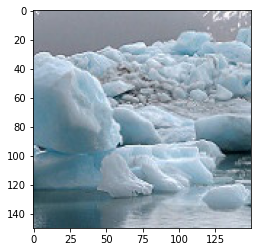

In [10]:
img = image.load_img("/content/drive/MyDrive/Dicoding/ProyekAkhir/sets/seg_train/seg_train/glacier/13.jpg")
imgplot = plt.imshow(img)

# Mengaplikasikan Image Augmentation dengan ImageDataGenerator dan Membagi Dataset Menjadi Data Training dan Data Testing

Data akan difokuskan pada folder data "seg_train" untuk keperluan pembagian data. Dalam folder ini data akan diklasifikasikan berdasarkan data training dan data testing sesuai ketentuan rasio test set sebesar 20% dari total dataset.

In [11]:
#data generator dengan validation size = 0.2
val_size = 0.2

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   validation_split = val_size)
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 20,
                                 zoom_range = 0.2,
                                 shear_range = 0.2,
                                 fill_mode = 'nearest',
                                 validation_split = val_size)

In [12]:
#pemisahan data
train_generator = train_datagen.flow_from_directory(
    dir_dataset,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical",
    subset="training") # set as training data
val_generator = val_datagen.flow_from_directory(
    dir_dataset,
    target_size=(150, 150),
    batch_size=64,
    class_mode="categorical",
    subset="validation") #set as validation data

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [13]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [14]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

#Pembuatan Model Menggunakan Model Sequential, Conv2D, dan Maxpooling Layer

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")  
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)       

# Melakukan Compile Model dan Melakukan Training pada Model

In [39]:
Adam(learning_rate=0.00146, name="Adam")
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics = ["accuracy"])

In [40]:
#penggunaan callback pada model
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [41]:
#melakukan training pada model
with tf.device("/device:GPU:0"):
  history = model.fit(train_generator,
                      validation_data = val_generator,
                      epochs = 20,
                      steps_per_epoch = 11230//64,
                      verbose = 1,
                      validation_steps = 2804//64,
                      callbacks = [lr_schedule, tb_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
175/175 [==============================] - 91s 519ms/step - loss: 1.2562 - accuracy: 0.5010 - val_loss: 1.0768 - val_accuracy: 0.6065
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
175/175 [==============================] - 90s 514ms/step - loss: 0.9576 - accuracy: 0.6307 - val_loss: 0.9994 - val_accuracy: 0.6116
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
175/175 [==============================] - 90s 515ms/step - loss: 0.8453 - accuracy: 0.6834 - val_loss: 0.8652 - val_accuracy: 0.6893
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
175/175 [==============================] - 86s 490ms/step - loss: 0.7570 - accuracy: 0.7185 - val_loss: 0.7427 - val_accuracy: 0.7391
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00100

# Model Evaluation dan Plot

In [42]:
#evaluasi pada train set
tscore = model.evaluate(train_generator)

print('Loss: {:.4f}'.format(tscore[0]))
print('Accuracy: {:.4f}'.format(tscore[1]))

176/176 [==============================] - 66s 376ms/step - loss: 0.3415 - accuracy: 0.8770
Loss: 0.3415
Accuracy: 0.8770


In [43]:
#evaluasi pada val set
vscore = model.evaluate(val_generator)

print('Loss: {:.4f}'.format(vscore[0]))
print('Accuracy: {:.4f}'.format(vscore[1]))

44/44 [==============================] - 17s 380ms/step - loss: 0.5023 - accuracy: 0.8263
Loss: 0.5023
Accuracy: 0.8263


Diketahui bahwa akurasi dari model > 80%

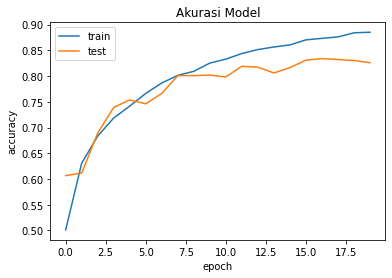

In [44]:
#accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

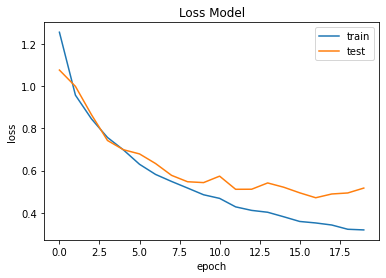

In [45]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Model Prediction

Saving 51.jpg to 51.jpg
GLACIER


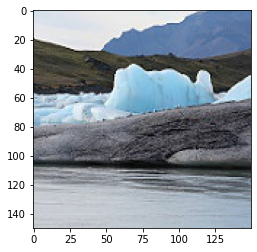

In [46]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=8)

  if classes[0,0]!=0:
    print("BUILDINGS")
  elif classes[0,1]!=0:
    print("FOREST")
  elif classes[0,2]!=0:
    print("GLACIER")
  elif classes[0,3]!=0:
    print("MOUNTAIN")
  elif classes[0,4]!=0:
    print("SEA")    
  else:
    print("STREET")

# Konversi Model dalam Format TF-Lite

In [47]:
#menghilangkan warning
warnings.filterwarnings('ignore')

In [48]:
#konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqipbtdee/assets


INFO:tensorflow:Assets written to: /tmp/tmpqipbtdee/assets


In [49]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)